# Workshop 3 — EDA & Feature Preparation (Happiness 2015–2019)

This notebook performs:
1) Loading and harmonizing the five CSV files (2015–2019)  
2) Basic inspection (common/unique columns, dtypes, missing values)  
3) Descriptive plots (scatter, histogram)  
4) Correlation matrix with one-hot encoding for any categorical columns  
5) Feature selection and normalization (scaling) ready for modeling  

> All visuals stay inside the notebook. No files are written to disk.


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
plt.rcParams.update({"figure.figsize": (6, 4), "figure.dpi": 130})

BASE = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]
DATA = BASE / "data"

def coerce_numeric(df: pd.DataFrame, cols):
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


In [3]:
years = [2015, 2016, 2017, 2018, 2019]
files = {y: DATA / f"{y}.csv" for y in years}
dfs = {y: pd.read_csv(p) for y, p in files.items()}

colsets = {y: set(df.columns) for y, df in dfs.items()}
common_cols = set.intersection(*colsets.values())
unique_cols = {y: sorted(list(colsets[y] - common_cols)) for y in years}

print("Common columns across 2015–2019:\n", sorted(common_cols))
print("\nUnique columns by year:")
for y in years:
    print(f" {y}: {unique_cols[y]}")


Common columns across 2015–2019:
 ['Generosity']

Unique columns by year:
 2015: ['Country', 'Dystopia Residual', 'Economy (GDP per Capita)', 'Family', 'Freedom', 'Happiness Rank', 'Happiness Score', 'Health (Life Expectancy)', 'Region', 'Standard Error', 'Trust (Government Corruption)']
 2016: ['Country', 'Dystopia Residual', 'Economy (GDP per Capita)', 'Family', 'Freedom', 'Happiness Rank', 'Happiness Score', 'Health (Life Expectancy)', 'Lower Confidence Interval', 'Region', 'Trust (Government Corruption)', 'Upper Confidence Interval']
 2017: ['Country', 'Dystopia.Residual', 'Economy..GDP.per.Capita.', 'Family', 'Freedom', 'Happiness.Rank', 'Happiness.Score', 'Health..Life.Expectancy.', 'Trust..Government.Corruption.', 'Whisker.high', 'Whisker.low']
 2018: ['Country or region', 'Freedom to make life choices', 'GDP per capita', 'Healthy life expectancy', 'Overall rank', 'Perceptions of corruption', 'Score', 'Social support']
 2019: ['Country or region', 'Freedom to make life choices',

In [4]:
KEEP = [
    "Country", "Year", "Happiness Score",
    "GDP per capita", "Social support", "Healthy life expectancy",
    "Freedom", "Perceptions of corruption",
]

ALIASES = {
    "Country or region": "Country", "Country name": "Country",
    "Score": "Happiness Score", "Happiness.Score": "Happiness Score", "Happiness score": "Happiness Score",
    "Economy (GDP per Capita)": "GDP per capita", "Economy..GDP.per.Capita.": "GDP per capita", "GDP per Capita": "GDP per capita",
    "Family": "Social support", "Social Support": "Social support",
    "Health (Life Expectancy)": "Healthy life expectancy", "Health..Life.Expectancy.": "Healthy life expectancy",
    "Freedom to make life choices": "Freedom",
    "Trust (Government Corruption)": "Perceptions of corruption",
    "Trust..Government.Corruption.": "Perceptions of corruption",
    "Perceptions of Corruption": "Perceptions of corruption",
}

def standardize_columns(df, year_val: int):
    df = df.rename(columns={c: ALIASES.get(c, c) for c in df.columns}).copy()
    if "Year" not in df.columns:
        df["Year"] = year_val
    for c in ["Happiness Score","GDP per capita","Social support","Healthy life expectancy","Freedom","Perceptions of corruption"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    cols = [c for c in KEEP if c in df.columns]
    df = df[cols].copy()
    if "Year" in df.columns:
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
    return df

frames = []
for y, df in dfs.items():
    frames.append(standardize_columns(df, y))

df_all = pd.concat(frames, ignore_index=True)

display(df_all.head(8))
df_all.info()


,Country,Year,Happiness Score,GDP per capita,Social support,Healthy life expectancy,Freedom,Perceptions of corruption
0,Switzerland,2015,7.587,1.39651,1.34951,0.94143,0.66557,0.41978
1,Iceland,2015,7.561,1.30232,1.40223,0.94784,0.62877,0.14145
2,Denmark,2015,7.527,1.32548,1.36058,0.87464,0.64938,0.48357
3,Norway,2015,7.522,1.45900,1.33095,0.88521,0.66973,0.36503
4,Canada,2015,7.427,1.32629,1.32261,0.90563,0.63297,0.32957
5,Finland,2015,7.406,1.29025,1.31826,0.88911,0.64169,0.41372
6,Netherlands,2015,7.378,1.32944,1.28017,0.89284,0.61576,0.31814
7,Sweden,2015,7.364,1.33171,1.28907,0.91087,0.65980,0.43844


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    782 non-null    object 
 1   Year                       782 non-null    Int64  
 2   Happiness Score            782 non-null    float64
 3   GDP per capita             782 non-null    float64
 4   Social support             782 non-null    float64
 5   Healthy life expectancy    782 non-null    float64
 6   Freedom                    782 non-null    float64
 7   Perceptions of corruption  781 non-null    float64
dtypes: Int64(1), float64(6), object(1)
memory usage: 49.8+ KB


In [5]:
na = df_all.isna().sum().sort_values(ascending=False)
display(na.to_frame("missing"))

display(df_all.describe(include="all"))

num_cols_all = [c for c in df_all.columns if c not in ["Country", "Year"]]
zscores = (df_all[num_cols_all] - df_all[num_cols_all].mean()) / df_all[num_cols_all].std(ddof=0)
outlier_mask = (zscores.abs() > 3).any(axis=1)
print(f"Rows flagged as outliers (|z| > 3): {outlier_mask.sum()} ({outlier_mask.mean():.1%})")


,missing
Perceptions of corruption,1
Country,0
Happiness Score,0
Year,0
GDP per capita,0
Social support,0
Healthy life expectancy,0
Freedom,0


,Country,Year,Happiness Score,GDP per capita,Social support,Healthy life expectancy,Freedom,Perceptions of corruption
count,782,782.0,782.000000,782.000000,782.000000,782.000000,782.000000,781.000000
unique,170,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
top,Switzerland,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
freq,5,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2016.993606,5.379018,0.916047,1.078392,0.612416,0.411091,0.125436
std,NaN,1.417364,1.127456,0.407340,0.329548,0.248309,0.152880,0.105816
min,NaN,2015.0,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,2016.0,4.509750,0.606500,0.869363,0.440183,0.309768,0.054000
50%,NaN,2017.0,5.322000,0.982205,1.124735,0.647310,0.431000,0.091000
75%,NaN,2018.0,6.189500,1.236187,1.327250,0.808000,0.531000,0.156030


Rows flagged as outliers (|z| > 3): 18 (2.3%)


In [6]:
MODEL_COLS = [
    "GDP per capita","Social support","Healthy life expectancy",
    "Freedom","Perceptions of corruption","Happiness Score"
]

before = len(df_all)
df_clean = df_all.dropna(subset=MODEL_COLS).copy()
after = len(df_clean)
print(f"Rows before: {before} | after dropna on model columns: {after} | removed: {before - after}")


Rows before: 782 | after dropna on model columns: 781 | removed: 1


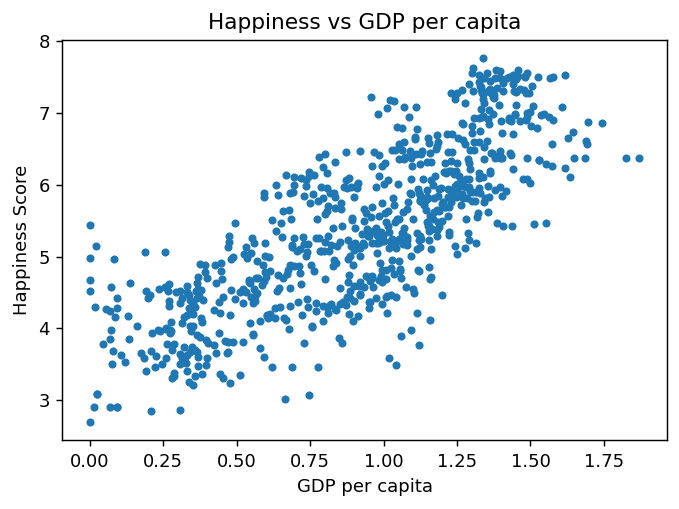

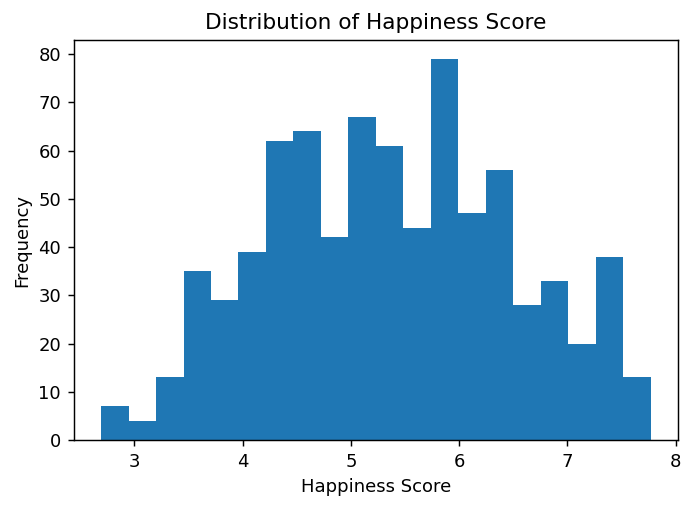

In [7]:
plt.figure()
plt.scatter(df_clean["GDP per capita"], df_clean["Happiness Score"], s=12)
plt.xlabel("GDP per capita"); plt.ylabel("Happiness Score")
plt.title("Happiness vs GDP per capita")
plt.show()

plt.figure()
plt.hist(df_clean["Happiness Score"], bins=20)
plt.xlabel("Happiness Score"); plt.ylabel("Frequency")
plt.title("Distribution of Happiness Score")
plt.show()


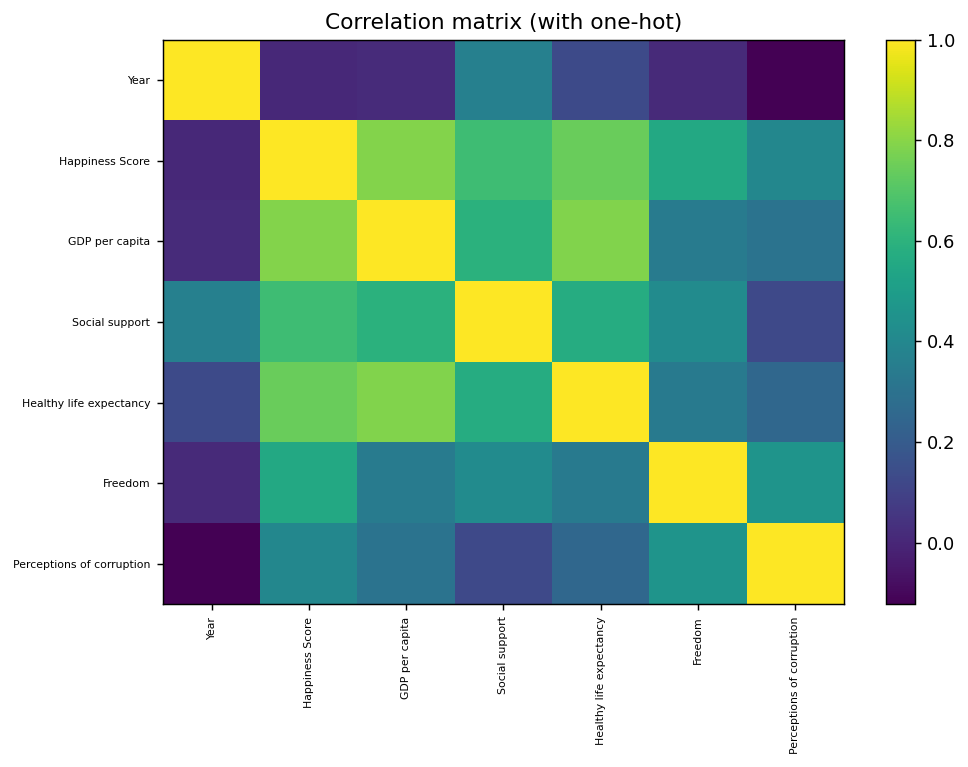

,abs(corr with Happiness)
GDP per capita,0.789719
Healthy life expectancy,0.742843
Social support,0.651246
Freedom,0.553365
Perceptions of corruption,0.398418
Year,0.005946


In [8]:
corr_base = df_clean.drop(columns=["Country"]).copy()
corr_enc = pd.get_dummies(corr_base, drop_first=True)
corr = corr_enc.corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(corr.shape[0]), corr.index, fontsize=6)
plt.title("Correlation matrix (with one-hot)")
plt.colorbar()
plt.tight_layout()
plt.show()

target = "Happiness Score"
top_corr = (corr[target].drop(labels=[target]).abs().sort_values(ascending=False).head(10))
display(top_corr.to_frame("abs(corr with Happiness)"))


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

FEATURES = [
    "GDP per capita",
    "Social support",
    "Healthy life expectancy",
    "Freedom",
    "Perceptions of corruption",
]
TARGET = "Happiness Score"

X = df_clean[FEATURES].copy()
y = df_clean[TARGET].astype(float)

use_standard = True
if use_standard:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    scaler_name = "StandardScaler (mean=0, std=1)"
else:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    scaler_name = "MinMaxScaler (0–1)"

X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURES)
print("Scaler used:", scaler_name)
display(X_scaled_df.head(8))


Scaler used: StandardScaler (mean=0, std=1)


,GDP per capita,Social support,Healthy life expectancy,Freedom,Perceptions of corruption
0,1.189637,0.821963,1.325365,1.664237,2.783433
1,0.957151,0.982026,1.351180,1.423419,0.151438
2,1.014316,0.855573,1.056376,1.558290,3.386656
3,1.343879,0.765613,1.098945,1.691459,2.265696
4,1.016316,0.740292,1.181184,1.450903,1.930373
5,0.927359,0.727085,1.114652,1.507967,2.726127
6,1.024091,0.611440,1.129674,1.338282,1.822286
7,1.029694,0.638462,1.202288,1.626478,2.959889


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.30, random_state=42
)

print("Train size:", X_train.shape, "| Test size:", X_test.shape)
display(pd.DataFrame({"set": ["train","test"], "rows": [len(X_train), len(X_test)]}))


Train size: (546, 5) | Test size: (235, 5)


,set,rows
0,train,546
1,test,235


## EDA & Feature Preparation — Conclusions

- We merged the five yearly files (2015–2019) and aligned on the common columns.  
- We **created `Year`** from the file when it was missing (e.g., 2018–2019).  
- After coercing numeric types, we dropped rows with missing values in the model columns only (features + target).  
- Visual inspection shows a clear positive relationship between **GDP per capita** and **Happiness Score**, and a unimodal distribution for the target.  
- The correlation matrix (with one-hot encoding) confirms the strongest associations typically include **GDP per capita**, **Healthy life expectancy**, and **Social support**.  
- Selected features (consistent 2015–2019):  
  `GDP per capita`, `Social support`, `Healthy life expectancy`, `Freedom`, `Perceptions of corruption`.  
- Features were **normalized** using **StandardScaler** (zero-mean, unit-variance). MinMax can be used if preferred.


## Outliers — detección y efecto en el modelo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Config 
FEATURES = [
    'GDP per capita',
    'Social support',
    'Healthy life expectancy',
    'Freedom',
    'Perceptions of corruption',
]
TARGET = 'Happiness Score'
ID_COLS = ['Country','Year']


In [12]:
def iqr_fences(s: pd.Series, k: float = 1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

out_summary = []
for col in FEATURES:
    s = pd.to_numeric(df_all[col], errors='coerce')
    low, high = iqr_fences(s, k=1.5)
    mask_iqr = (s < low) | (s > high)
    mu, sigma = s.mean(), s.std(ddof=0)
    z = (s - mu) / (sigma if sigma != 0 else 1.0)
    mask_z = z.abs() > 3
    out_summary.append({
        'feature': col,
        'IQR_low': low,
        'IQR_high': high,
        'IQR_outliers': int(mask_iqr.sum()),
        'IQR_%': float(mask_iqr.mean()*100),
        'Z>3_outliers': int(mask_z.sum()),
        'Z>3_%': float(mask_z.mean()*100),
        'n': int(s.notna().sum())
    })
out_df = pd.DataFrame(out_summary).sort_values('IQR_%', ascending=False)
out_df

,feature,IQR_low,IQR_high,IQR_outliers,IQR_%,Z>3_outliers,Z>3_%,n
4,Perceptions of corruption,-0.099045,0.309075,67,8.567775,13,1.662404,781
1,Social support,0.182531,2.014081,10,1.278772,5,0.639386,782
0,GDP per capita,-0.338031,2.180718,0,0.000000,0,0.000000,782
2,Healthy life expectancy,-0.111544,1.359726,0,0.000000,0,0.000000,782
3,Freedom,-0.022081,0.862849,0,0.000000,0,0.000000,782


In [13]:
rows = []
for col in FEATURES:
    for y, g in df_all.groupby('Year'):
        s = pd.to_numeric(g[col], errors='coerce')
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask = (s < low) | (s > high)
        rows.append({
            'feature': col, 'year': int(y),
            'n': int(s.notna().count()),
            'outliers_IQR': int(mask.sum()),
            'outliers_%': float(mask.mean()*100)
        })
out_by_year = pd.DataFrame(rows).sort_values(['feature','year'])
out_by_year.head(20)

,feature,year,n,outliers_IQR,outliers_%
15,Freedom,2015,158,0,0.000000
16,Freedom,2016,157,0,0.000000
17,Freedom,2017,155,0,0.000000
18,Freedom,2018,156,2,1.282051
19,Freedom,2019,156,1,0.641026
0,GDP per capita,2015,158,0,0.000000
1,GDP per capita,2016,157,0,0.000000
2,GDP per capita,2017,155,0,0.000000
3,GDP per capita,2018,156,1,0.641026
4,GDP per capita,2019,156,0,0.000000


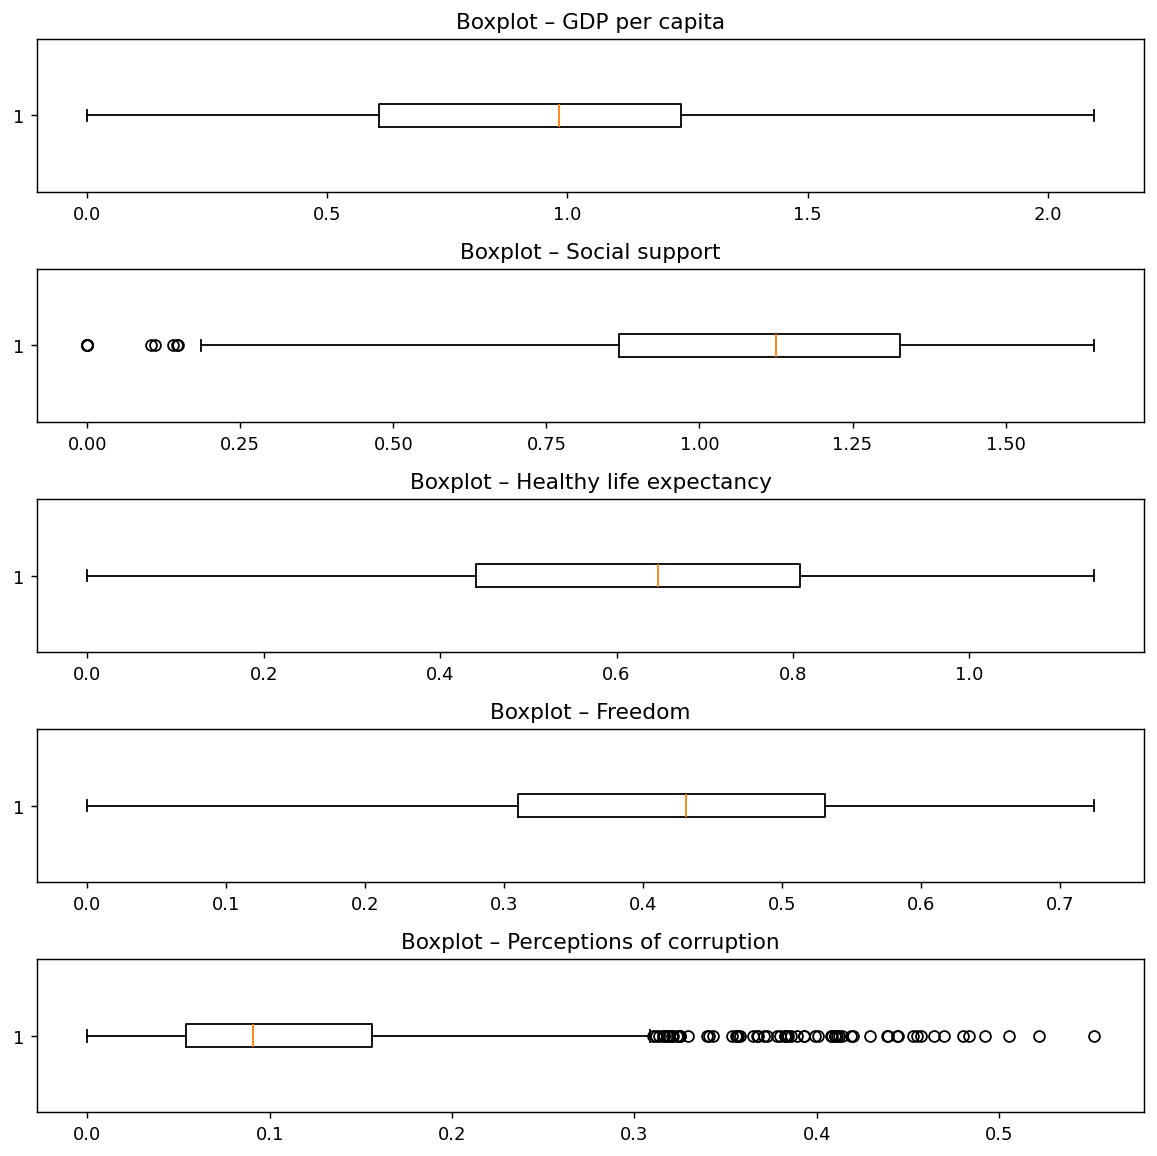

In [14]:
fig, axes = plt.subplots(len(FEATURES), 1, figsize=(9, 1.8*len(FEATURES)))
if len(FEATURES) == 1:
    axes = [axes]
for ax, col in zip(axes, FEATURES):
    s = pd.to_numeric(df_all[col], errors='coerce').dropna()
    ax.boxplot(s, vert=False)
    ax.set_title(f'Boxplot – {col}')
plt.tight_layout(); plt.show()

### Comparación del modelo (baseline vs winsorize vs IQR)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def eval_model(df):
    data = df[ID_COLS + FEATURES + [TARGET]].dropna()
    X = data[FEATURES].astype(float)
    y = data[TARGET].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42
    )

    m = LinearRegression()
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)

    r2  = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)   # sin 'squared'
    rmse = mse ** 0.5                          # raíz cuadrada

    return {"R2": r2, "MAE": mae, "RMSE": rmse}

baseline_metrics = eval_model(df_all.copy())
baseline_metrics


{'R2': 0.7474971745537753,
 'MAE': 0.4350700358778136,
 'RMSE': 0.5615140754122675}

In [17]:
def winsorize_df(df, cols, lo=0.01, hi=0.99):
    df2 = df.copy()
    for c in cols:
        s = pd.to_numeric(df2[c], errors='coerce')
        lo_v, hi_v = s.quantile(lo), s.quantile(hi)
        df2[c] = s.clip(lo_v, hi_v)
    return df2

df_cap = winsorize_df(df_all, FEATURES, lo=0.01, hi=0.99)
cap_metrics = eval_model(df_cap)
cap_metrics

{'R2': 0.750291021198072,
 'MAE': 0.43128155472492685,
 'RMSE': 0.5583989659362039}

In [18]:
def drop_iqr_outliers(df, cols, k=1.5):
    df2 = df.copy()
    mask_keep = pd.Series(True, index=df2.index)
    for c in cols:
        s = pd.to_numeric(df2[c], errors='coerce')
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - k*iqr, q3 + k*iqr
        mask_keep &= s.between(low, high) | s.isna()
    return df2[mask_keep].copy()

df_iqr = drop_iqr_outliers(df_all, FEATURES, k=1.5)
iqr_metrics = eval_model(df_iqr)
iqr_metrics

{'R2': 0.6778211873582369,
 'MAE': 0.42761801174711994,
 'RMSE': 0.5494647376931406}

In [19]:
pd.DataFrame([
    {'data':'Baseline (sin tocar)', **baseline_metrics},
    {'data':'Winsorize 1–99%', **cap_metrics},
    {'data':'Drop IQR 1.5x', **iqr_metrics},
])


,data,R2,MAE,RMSE
0,Baseline (sin tocar),0.747497,0.435070,0.561514
1,Winsorize 1–99%,0.750291,0.431282,0.558399
2,Drop IQR 1.5x,0.677821,0.427618,0.549465


### Conclusión (guía)
- Detección: resume `out_df` y `out_by_year`.
- Comparación: usa la tabla (baseline vs winsorize vs IQR).
- Decisión: solo aplicar tratamiento si mejora MAE/RMSE sin castigar R2. El dataset original no se altera; cualquier tratamiento se hace en copia.